# Performance comparison of inference on dyngen data

Notebook compares metrics for velocity, latent time and GRN inference across different methods applied to dyngen-generated data.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

from rgv_tools import DATA_DIR, FIG_DIR
from rgv_tools.plotting._significance import get_significance

## Constants

In [2]:
DATASET = "dyngen"

In [ ]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [5]:
VELOCITY_METHODS = ["regvelo", "velovi", "scvelo", "velovae_fullvb", "velovae_vae", "tfvelo", "cell2fate", "unitvelo"]
VELOCITY_METHODS_TF = ["regvelo", "tfvelo"]
TIME_METHODS = ["regvelo", "velovi", "scvelo"]
GRN_METHODS = ["regvelo", "tfvelo", "grnboost2", "celloracle", "splicejac", "correlation"]

In [6]:
GRN_METHOD_PALETTE = {
    "regvelo": "#0173b2",
    "correlation": "#D3D3D3",
    "grnboost2": "#D3D3D3",  # 708090
    "celloracle": "#D3D3D3",  # A9A9A9
    "tfvelo": "#696969",  # 696969
    "splicejac": "#D3D3D3",
}

VELO_METHOD_PALETTE = {
    "regvelo": "#0173b2",
    "velovi": "#de8f05",
    "scvelo": "#029e73",
    "tfvelo": "#D3D3D3",
    "unitvelo": "#D3D3D3",
    "velovae_vae": "#D3D3D3",
    "velovae_fullvb": "#D3D3D3",
    "cell2fate": "#D3D3D3",
}

TIME_METHOD_PALETTE = {
    "regvelo": "#0173b2",
    "velovi": "#de8f05",
    "scvelo": "#029e73",
}

## Data loading

### velocity benchmark

In [7]:
scale_df = []
for scale in range(1, 5):
    df_tfvelo = pd.read_parquet(
        DATA_DIR / DATASET / f"complexity_{scale}" / "results" / "tfvelo_correlation_all.parquet"
    )
    velocity_correlation_tf = []

    for col in df_tfvelo:
        df_tf = df_tfvelo[col]

        df_tf = df_tf.reset_index(drop=True)

        nan_indices = df_tf[df_tf.isnull()].index

        tf_sub = df_tf.drop(nan_indices, axis=0)

        n_tf = len(tf_sub)

        velocity_correlation_tf.append(np.mean(tf_sub))

    correlation_df = []
    time_df = []
    grn_df = []

    for method in VELOCITY_METHODS:
        df = pd.read_parquet(DATA_DIR / DATASET / f"complexity_{scale}" / "results" / f"{method}_correlation.parquet")
        df.columns = f"{method}_" + df.columns
        correlation_df.append(df)

    for method in TIME_METHODS:
        df = pd.read_parquet(DATA_DIR / DATASET / f"complexity_{scale}" / "results" / f"{method}_correlation.parquet")
        df.columns = f"{method}_" + df.columns
        time_df.append(df)

    for method in GRN_METHODS:
        df = pd.read_parquet(DATA_DIR / DATASET / f"complexity_{scale}" / "results" / f"{method}_correlation.parquet")
        df.columns = f"{method}_" + df.columns
        grn_df.append(df)

    correlation_df = pd.concat(correlation_df, axis=1)
    time_df = pd.concat(time_df, axis=1)
    grn_df = pd.concat(grn_df, axis=1)

    if len(velocity_correlation_tf) < correlation_df.shape[0]:
        velocity_correlation_tf += [np.nan] * (correlation_df.shape[0] - len(velocity_correlation_tf))
    correlation_df["tfvelo_velocity"] = velocity_correlation_tf

    df = correlation_df.loc[:, correlation_df.columns.str.contains("velocity")]
    df.columns = df.columns.str.removesuffix("_velocity")
    df = pd.melt(df, var_name="method", value_name="correlation")
    df["correlation"] = (df["correlation"] + 1) / 2
    df["scale"] = str(scale)

    scale_df.append(df)

In [8]:
df = pd.concat(scale_df, axis=0)

In [9]:
df = df.reset_index(drop=True)

### Velocity

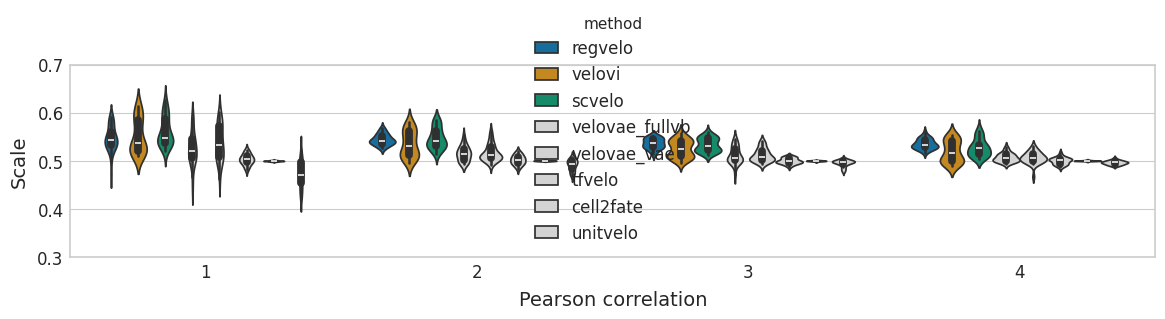

In [10]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 2.5))
    sns.violinplot(
        data=df,
        y="correlation",
        x="scale",
        hue="method",
        hue_order=VELOCITY_METHODS,
        palette=VELO_METHOD_PALETTE,
        ax=ax,
    )

    ax.set(
        xlabel="Pearson correlation",
        ylabel="Scale",
        yticks=ax.get_yticks(),
    )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "velocity_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()

### GRN benchmark

In [ ]:
scale_df = []
for scale in range(1, 5):
    grn_df = []
    for method in GRN_METHODS:
        df = pd.read_parquet(f"results/complexity_{scale}/{method}_correlation.parquet")
        df.columns = f"{method}_" + df.columns
        grn_df.append(df)

    grn_df = pd.concat(grn_df, axis=1)

    grn_df_sub = grn_df.copy()
    grn_df_sub = grn_df_sub.dropna()
    grn_df_sub

    df = grn_df_sub.loc[:, grn_df.columns.str.contains("grn")]
    df.columns = df.columns.str.removesuffix("_grn")
    df = pd.melt(df, var_name="method").rename(columns={"value": "correlation"})
    df["scale"] = str(scale)

    scale_df.append(df)

In [ ]:
df = pd.concat(scale_df, axis=0)
df = df.reset_index(drop=True)

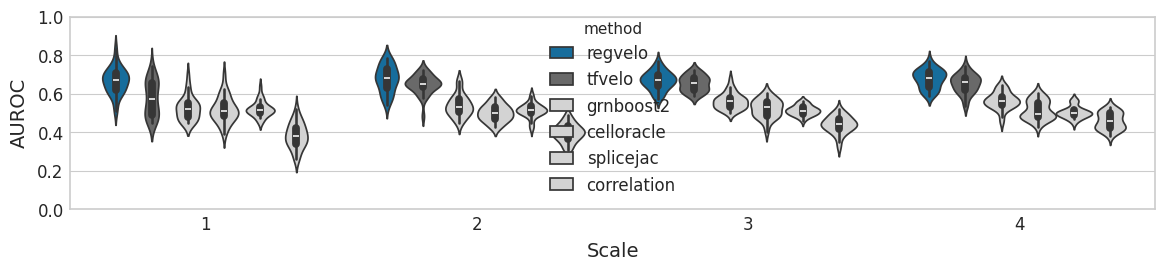

In [ ]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(14, 2.5))
    sns.violinplot(
        data=df, y="correlation", x="scale", hue="method", hue_order=GRN_METHODS, palette=GRN_METHOD_PALETTE, ax=ax
    )

    ax.set(
        ylabel="AUROC",
        xlabel="Scale",
        yticks=ax.get_yticks(),
    )

    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "GRN_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()

## Latent time

In [28]:
scale_df = []
for scale in range(1, 5):
    time_df = []
    for method in TIME_METHODS:
        df = pd.read_parquet(DATA_DIR / DATASET / f"complexity_{scale}" / "results" / f"{method}_correlation.parquet")
        df.columns = f"{method}_" + df.columns
        time_df.append(df)

    time_df = pd.concat(time_df, axis=1)

    ttest_res = ttest_rel(
        time_df["regvelo_time"],
        time_df["velovi_time"],
        alternative="greater",
    )

    print(ttest_res)
    significance = get_significance(pvalue=ttest_res.pvalue)

    time_df_sub = time_df.copy()
    time_df_sub = time_df_sub.dropna()
    time_df_sub

    df = time_df_sub.loc[:, time_df.columns.str.contains("time")]
    df.columns = df.columns.str.removesuffix("_time")
    df = pd.melt(df, var_name="method", value_name="correlation")
    df["scale"] = str(scale)

    scale_df.append(df)

TtestResult(statistic=2.819809533651689, pvalue=0.004287626705348869, df=29)
TtestResult(statistic=6.817578655205317, pvalue=8.6925544495783e-08, df=29)
TtestResult(statistic=7.716392336845313, pvalue=8.252679776252025e-09, df=29)
TtestResult(statistic=5.498852429313436, pvalue=3.1735361936536186e-06, df=29)


In [52]:
df = pd.concat(scale_df, axis=0)
df = df.reset_index(drop=True)

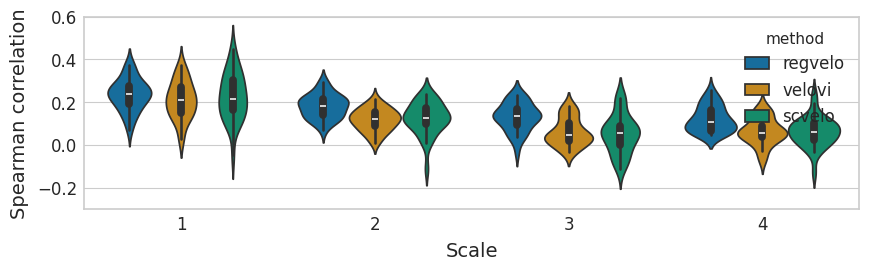

In [25]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(10, 2.5))
    sns.violinplot(
        data=df, y="correlation", x="scale", hue="method", hue_order=TIME_METHODS, palette=TIME_METHOD_PALETTE, ax=ax
    )

    ax.set(
        ylabel="Spearman correlation",
        xlabel="Scale",
        yticks=ax.get_yticks(),
    )
    ax.set_ylim(-0.3, 0.6)
    if SAVE_FIGURES:
        fig.savefig(
            FIG_DIR / DATASET / "time_benchmark.svg",
            format="svg",
            transparent=True,
            bbox_inches="tight",
        )

    plt.show()